In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from functools import partial
from scipy.spatial import distance
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import Normalizer
from numpy.fft import fft
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train=pd.read_csv('/Users/zuza/Desktop/X_train.csv')

In [3]:
X_train.head()

,time,seconds_elapsed_orientation,qz_orientation,qy_orientation,qx_orientation,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,seconds_elapsed_location,...,horizontalAccuracy_location_network,speed_location_network,bearing_location_network,altitude_location_network,longitude_location_network,latitude_location_network,seconds_elapsed_gravity,z_gravity,y_gravity,x_gravity
0,1694857537318869200,1228.074843,-0.626221,0.386100,-0.674631,0.060399,-1.826153,0.600508,-2.571477,1228.069,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,1228.074843,-2.041392,-5.524593,7.841044
1,1694857182616775700,873.374776,-0.013953,-0.618994,-0.425122,0.660245,-1.723670,0.575310,0.706575,873.070,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,873.374776,-1.252387,-5.323759,8.139995
2,1694850675496257000,488.368257,0.529413,-0.843842,0.045404,0.074776,-2.755124,1.090140,-0.343697,488.191,...,800.000000,0.0,0.0,0.0,3.123176,50.672179,488.368257,-4.202703,-8.689218,1.733541
3,1694856574973923600,265.731924,-0.103478,-0.568592,-0.501415,0.643878,-1.747675,0.556275,0.976151,265.072,...,149.600006,0.0,0.0,66.5,3.097713,50.681150,265.731924,-1.467729,-5.174577,8.199995
4,1697611168928672300,191.401327,-0.176786,0.565639,-0.799976,0.094012,-2.952015,0.358007,-1.945084,191.092,...,34.563000,0.0,0.0,90.5,3.132056,50.687971,191.401327,-9.001679,-3.482618,1.735401


In [4]:
#  We identified outliers in the following columns during Exploratory Data Analysis (EDA):
#  ['speedAccuracy_location', 'vertical_accuracy_location_network', 'horizontalAccuracy_location',
#  'verticalAccuracy_location', 'speed_location', 'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
#  'horizontalAccuracy_location_gps', 'atitude_location_gps', 'verticalAccuracy_location_network',
#  'horizontalAccuracy_location_network', 'atitude_location_network'].
#  We'll replace these outliers with the 0.95 quantille value for each respective column.

class OutlierHandlerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.percentiles = {}

    def fit(self, X, y=None):
        for column in self.columns:
            self.percentiles[column] = np.percentile(X[column], 95)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = np.where(X_copy[column] > self.percentiles[column], 
                                      self.percentiles[column], 
                                      X_copy[column])
        return X_copy

In [5]:
# Since it was observed through exploratory data analysis (EDA) that columns related to elapsed time are similar, 
# we want to consolidate them by calculating their mean value. This transformer computes the average of the elapsed time
# values and removes the individual columns to avoid redundant information.

class AverageSecondsElapsedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='seconds_elapsed_'):
        self.keyword = keyword
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['seconds_elapsed_time'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [109]:
len(X_train['seconds_elapsed_pedometer'].loc[X_train['seconds_elapsed_pedometer']<0])/len(X_train)

0.19810154013398834

In [6]:
# We have decided to drop the seconds_elapsed_time_pedometer column from our dataset. This decision is based on 
# the fact that 20% of its values are negative, and we are uncertain about the cause (possibly a device issue or a time shift). 
# Since we have other columns capturing elapsed time, we can safely remove this problematic column.

# Additionally, we will use a transformer to drop columns that contain only a single unique value, as they do not 
# provide any useful information for our model. We will also drop the original time column after extracting relevant time features from it.

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is not None:
            X = X.drop(columns=self.columns, errors='ignore')
        return X

In [111]:
# Since we already have roll, pitch and yaw orientation values
# we do not need to convert quaterions (qx, qy, qz, qw) to Euler angles.

In [7]:
# Adding time features to capture the hour and minute of the day, which may be relevant for detecting patterns
# in the data. Since we are extracting time features, we will drop the original time column, which serves a role
# in our dataset similar to primary key.

class TimeFeatureExtraction(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['time'] = pd.to_datetime(X['time'], unit='ns')
        X['hour'] = X['time'].dt.hour
        X['minute'] = X['time'].dt.minute
        return X

In [8]:
# Based on our exploratory data analysis (EDA), we have identified that there are columns containing speed values. 
# We can reasonably assume that these speed-related columns will be among the most important features for our clasterization activity model.

X_train['speed_location_gps'].corr(X_train['speed_location'])

0.9808731877586917

In [114]:
# xGPS data tends to offer higher accuracy as it relies on satellite signals. However, its precision may fluctuate 
# due to atmospheric conditions or terrain. On the other hand, location data can be more reliable in areas where 
# GPS signals are inaccessible, such as indoors or in regions with poor signal coverage.

X_train[['speed_location_gps', 'speed_location']].loc[X_train['speed_location_gps']!=X_train['speed_location']]

,speed_location_gps,speed_location
0,6.602857,6.583204
1,5.193032,5.214794
2,4.892950,4.993772
3,5.824082,5.807374
4,6.181814,6.133829
...,...,...
1543562,0.000000,0.835902
1543563,0.800908,0.854354
1543564,3.083701,2.689046
1543565,0.949663,1.058741


In [115]:
print(X_train['speed_location_gps'].describe(), X_train['speed_location'].describe())

count    1.543567e+06
mean     2.987227e+00
std      2.745493e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.486108e+00
75%      5.497233e+00
max      1.074791e+01
Name: speed_location_gps, dtype: float64 count    1.543567e+06
mean     3.040514e+00
std      2.700369e+00
min      0.000000e+00
25%      2.457211e-01
50%      2.538605e+00
75%      5.501579e+00
max      1.514773e+01
Name: speed_location, dtype: float64


In [116]:
len(X_train['speed_location_gps']==0), len(X_train['speed_location']==0)

(1543567, 1543567)

In [8]:
# After careful analysis of these two variables, considering their relatively minor discrepancies,
#  we've opted to compute a simple mean of these columns and consolidate them into a single column named 'speed'.

class AverageSpeedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='speed_location'):
        self.keyword = keyword
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['speed'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [9]:
# In our data frame we have 3 different devices representing the geographical location, these are: location, location_gps and
# location_network. To avoid data redundancy and reduce the dimensionality of the data, we average the position data. 
# However, as EDA showed, the data collected from location_network differs significantly from the data collected by location
# and location_gps. This is most likely due to the Internet being turned off during activity, loss of Internet connection or
# interruptions. So we made the decision to average the data from location and location_gps and discard the data from 
# location_network.

class AverageLocationTransformer(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['longitude'] = X[['longitude_location_gps', 'longitude_location']].mean(axis=1)
        X['latitude'] = X[['latitude_location_gps', 'latitude_location']].mean(axis=1)
        X['altitude'] = X[['altitude_location_gps', 'altitude_location']].mean(axis=1)
        X = X.drop(['longitude_location_gps', 'longitude_location', 'longitude_location_network',
                   'latitude_location_gps', 'latitude_location', 'latitude_location_network',
                   'altitude_location_gps', 'altitude_location', 'altitude_location_network'], axis=1)

        return X

In [10]:
# In the columns total_acceleration, magnetometer, gyroscope, gravity, accelerometer there are 3 dimensions x y z.
# In order to change the dimensionality, we will convert the vector x y z to the Euclidean norm of this vector.

class AccelerationMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['acceleration_magnitude'] = np.sqrt(X['x_total_acceleration']**2 + X['y_total_acceleration']**2 + X['z_total_acceleration']**2)
        X = X.drop(['x_total_acceleration', 'y_total_acceleration', 'z_total_acceleration'], axis=1)
        return X
    
class MagnetometerMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['magnetometer_magnitude'] = np.sqrt(X['x_magnetometer']**2 + X['y_magnetometer']**2 + X['z_magnetometer']**2)
        X = X.drop(['x_magnetometer', 'y_magnetometer', 'z_magnetometer'], axis=1)
        return X
    
class GyroscopeIntegrationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['angular_velocity'] = np.sqrt(X['x_gyroscope']**2 + X['y_gyroscope']**2 + X['z_gyroscope']**2)
        X = X.drop(['x_gyroscope', 'y_gyroscope', 'z_gyroscope'], axis=1)
        return X
    
class GravitationMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['gravitation_magnitude'] = np.sqrt(X['x_gravity']**2 + X['y_gravity']**2 + X['z_gravity']**2)
        X = X.drop(['x_gravity', 'y_gravity', 'z_gravity'], axis=1)
        return X


class AccelerometerMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['accelerometer_magnitude'] = np.sqrt(X['x_accelerometer']**2 + X['y_accelerometer']**2 + X['z_accelerometer']**2)
        X = X.drop(['x_accelerometer', 'y_accelerometer', 'z_accelerometer'], axis=1)
        return X


In [60]:
# Finally, we will normalize the features, including geographical coordinates, as our area is small, 
# making Euclidean distance appropriate for our purposes.

# Additionally, we'll utilize a custom normalizer to preserve the structure of the DataFrame.

class PandasNormalizer(Normalizer):
    def fit_transform(self, X, y=None):
        scaled_data = super().fit_transform(X)
        return pd.DataFrame(scaled_data, columns=X.columns, index=X.index)

In [12]:
class DistanceCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lat_index = 'latitude'
        self.lon_index = 'longitude'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['distance'] = X.apply(lambda row: self.haversine(row[self.lat_index], row[self.lon_index]), axis=1)
        return X

    @staticmethod
    def haversine(lat, lon):
        R = 6371.0
        lat1 = math.radians(lat)
        lon1 = math.radians(lon)
        dlat = lat1 - math.radians(0) 
        dlon = lon1 - math.radians(0) 
        a = math.sin(dlat / 2)**2 + math.cos(0) * math.cos(lat1) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c

        return distance

In [132]:
class SumSquareFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, acceleration_col, velocity_col):
        self.acceleration_col = acceleration_col
        self.velocity_col = velocity_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['sum_square'] = X[self.acceleration_col]**2 + X[self.velocity_col]**2
        return X

In [198]:
pipeline = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network",'qz_orientation', 'qy_orientation',
                                        'qx_orientation', 'qw_orientation',
                                        'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network'])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_transformer', AverageSpeedTransformer()),
    ('average_location_transformer', AverageLocationTransformer()),
    ('acceleration_magnitude_transformer', AccelerationMagnitudeTransformer()),
    ('magnetometer_magnitude_transformer', MagnetometerMagnitudeTransformer()),
    ('gyroscope_integration_transformer', GyroscopeIntegrationTransformer()),
    ('gravitation_magnitude_transformer', GravitationMagnitudeTransformer()),
    ('accelerometer_magnitude_transformer', AccelerometerMagnitudeTransformer()),
    ('time_feature_extractor', TimeFeatureExtraction()),
    ('time_dropper', ColumnDropper(columns=['time'])),
    ('distance_calculator', DistanceCalculator()),
    ('sum_square', SumSquareFeatureExtractor('accelerometer_magnitude','speed')),
    ('scaler', PandasNormalizer())

])

In [199]:
X_train_transformed = pipeline.fit_transform(X_train)

In [200]:
X_train_transformed.head()

,roll_orientation,pitch_orientation,yaw_orientation,bearingAccuracy_location,speedAccuracy_location,verticalAccuracy_location,horizontalAccuracy_location,bearing_location,bearingAccuracy_location_gps,speedAccuracy_location_gps,...,altitude,acceleration_magnitude,magnetometer_magnitude,angular_velocity,gravitation_magnitude,accelerometer_magnitude,hour,minute,distance,sum_square
0,-0.000299,0.000098,-0.000421,0.001113,0.000196,0.002471,0.000638,0.033840,0.001113,0.000196,...,0.014337,0.001183,0.007659,0.000205,0.001605,0.000445,0.001473,0.007365,0.923663,0.008322
1,-0.000293,0.000098,0.000120,0.001700,0.000221,0.002448,0.001012,0.006121,0.001700,0.000221,...,0.011663,0.001838,0.008697,0.000039,0.001667,0.000205,0.001530,0.006631,0.959302,0.004852
2,-0.000480,0.000190,-0.000060,0.004648,0.000540,0.002751,0.000746,0.053819,0.004648,0.000540,...,0.010916,0.001371,0.009160,0.000172,0.001707,0.000365,0.001219,0.008879,0.982455,0.005020
3,-0.000308,0.000098,0.000172,0.001359,0.000212,0.003018,0.000688,0.011805,0.001359,0.000212,...,0.011876,0.001510,0.008607,0.000092,0.001731,0.000227,0.001588,0.005118,0.995817,0.006261
4,-0.000521,0.000063,-0.000343,0.000000,0.000000,0.000563,0.000749,0.038475,0.001994,0.000371,...,0.016068,0.001440,0.007923,0.000375,0.001731,0.000318,0.001059,0.006883,0.996029,0.007265


In [201]:
X_train_transformed.columns

Index(['roll_orientation', 'pitch_orientation', 'yaw_orientation',
       'bearingAccuracy_location', 'speedAccuracy_location',
       'verticalAccuracy_location', 'horizontalAccuracy_location',
       'bearing_location', 'bearingAccuracy_location_gps',
       'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'steps_pedometer', 'seconds_elapsed_time', 'speed', 'longitude',
       'latitude', 'altitude', 'acceleration_magnitude',
       'magnetometer_magnitude', 'angular_velocity', 'gravitation_magnitude',
       'accelerometer_magnitude', 'hour', 'minute', 'distance', 'sum_square'],
      dtype='object')

In [202]:
len(X_train_transformed.columns)

28

Theoretically, in the context of classifying modes of movement, the primary influencing factors are speed and acceleration. These variables are crucial because they directly reflect the dynamics of how an object or individual is moving. Consequently, we aim to investigate the behavior of these variables independently to understand their impact on movement classification better. By analyzing speed and acceleration separately, we can gain insights into how they contribute to distinguishing different movement patterns.


In [184]:
pipeline2 = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network",'qz_orientation', 'qy_orientation',
                                        'qx_orientation', 'qw_orientation', 'roll_orientation', 'pitch_orientation', 
                                       'yaw_orientation','bearingAccuracy_location', 'verticalAccuracy_location',
       'horizontalAccuracy_location', 'bearing_location', 'altitude_location',
       'longitude_location', 'latitude_location', 'z_magnetometer',
       'y_magnetometer', 'x_magnetometer', 'z_accelerometer',
       'y_accelerometer', 'x_accelerometer', 'bearingAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'altitude_location_gps', 'longitude_location_gps',
       'latitude_location_gps', 'z_gyroscope', 'y_gyroscope', 'x_gyroscope',
       'steps_pedometer', 'verticalAccuracy_location_network',
       'horizontalAccuracy_location_network', 'altitude_location_network',
       'longitude_location_network', 'latitude_location_network', 'z_gravity',
       'y_gravity', 'x_gravity', 'speedAccuracy_location_gps', 'time'])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_transformer', AverageSpeedTransformer()),
    ('acceleration_magnitude_transformer', AccelerationMagnitudeTransformer()),
    ('dropper2', ColumnDropper(columns=["seconds_elapsed_time"])),
    ('scaler', PandasNormalizer())
])

In [158]:
X_train_transformed2 = pipeline2.fit_transform(X_train)

In [159]:
X_train_transformed2.head()

,speedAccuracy_location,speed,acceleration_magnitude
0,0.121765,0.669000,0.733220
1,0.107704,0.431141,0.895833
2,0.316293,0.504371,0.803473
3,0.115235,0.558478,0.821476
4,0.000000,0.602421,0.798178


In [160]:
X_train_transformed2.columns

Index(['speedAccuracy_location', 'speed', 'acceleration_magnitude'], dtype='object')

In [161]:
pca2_2 = PCA(n_components=2)
principal_components2 = pca2_2.fit_transform(X_train_transformed2)

In [162]:
pca_df2 = pd.DataFrame(data=principal_components2, columns=['PC1', 'PC2'])

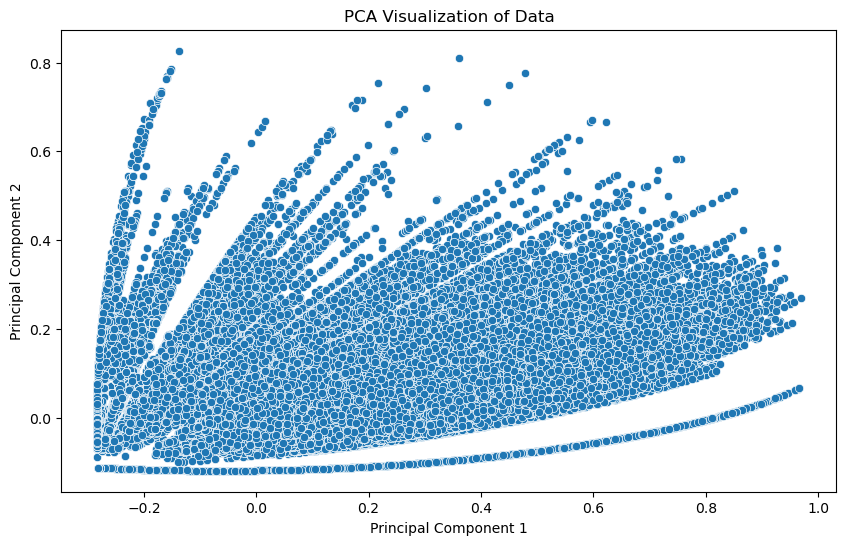

In [163]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df2)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [164]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed2)).iloc[0]:.4f}')
print(f'Explained variance: {pca2_2.explained_variance_[0]:.4f}')
print(pca2_2.explained_variance_ratio_)

Total variance: 0.3366
Explained variance: 0.0677
[0.82031364 0.16563561]


 We did not observe distinct clusters when analyzing the reduced dataset. Therefore, we decided to proceed with feature engineering on the entire dataset. By enriching the dataset with additional features derived from speed and acceleration, we hope to improve the accuracy and robustness of our classification model.

## PCA

In [203]:
# PCA for 2 components
pca2 = PCA(n_components=2)
principal_components = pca2.fit_transform(X_train_transformed)

In [204]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')
print(f'Explained variance: {pca2.explained_variance_[0]:.4f}')
print(pca2.explained_variance_ratio_)

Total variance: 0.0167
Explained variance: 0.0122
[0.89496791 0.05890854]


In [205]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

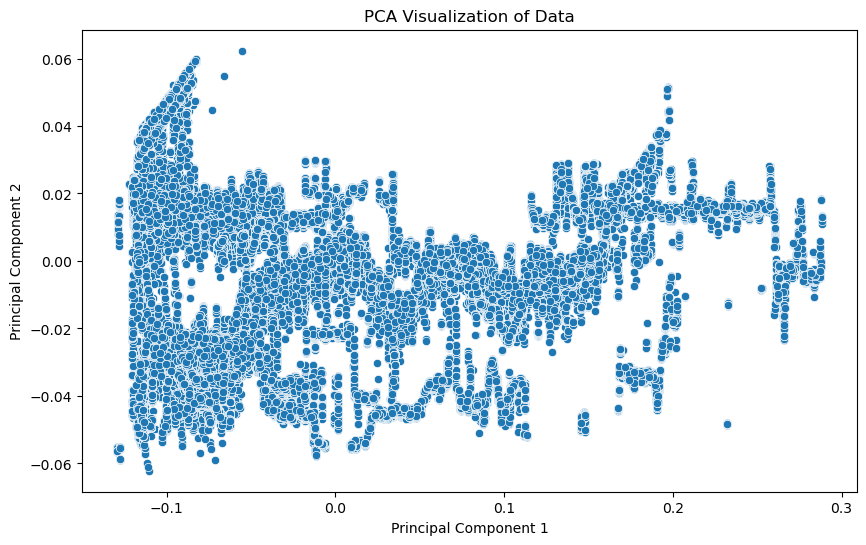

In [206]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [207]:
# PCA for 3 components
pca3 = PCA(n_components=3)
principal_components = pca3.fit_transform(X_train_transformed)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

In [208]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')
print(f'Explained variance: {pca3.explained_variance_[0]:.4f}')
print(pca3.explained_variance_ratio_)

Total variance: 0.0167
Explained variance: 0.0122
[0.89496791 0.05890854 0.01890749]


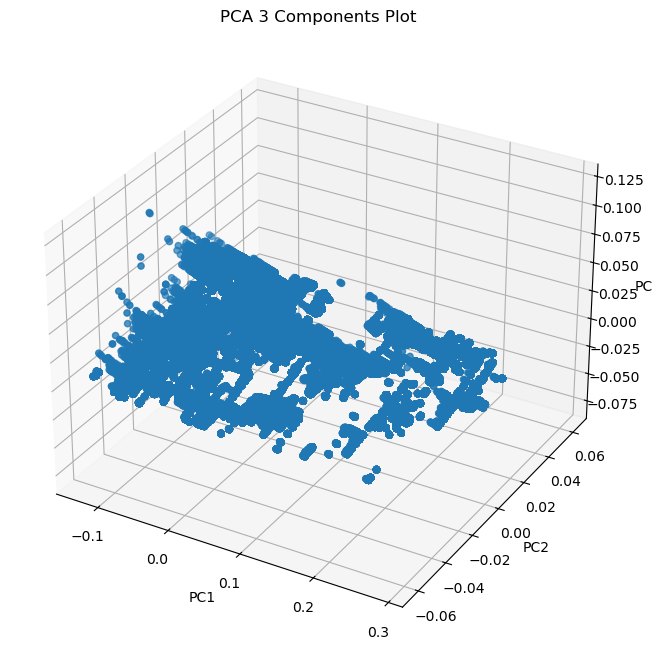

In [209]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3 Components Plot')
plt.show()

Text(0, 0.5, 'cumulative explained variance')

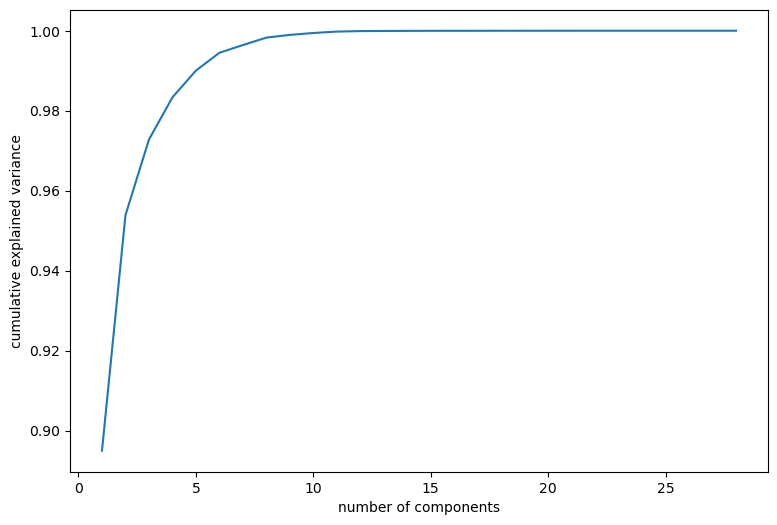

In [210]:
# We can observe that for approximately 3 components, we achieve a cumulative explained variance ratio of about 95%. 

pca = PCA().fit(X_train_transformed)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [211]:
# with 3 components we get cumulative explained variance at 0.95
num_components = 3

pca = PCA(n_components=num_components)
X_pca_reduced = pca.fit_transform(X_train_transformed)

In [212]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_reduced)
X_train_transformed['cluster'] = clusters

In [213]:
sample_size = min(10000, len(X_pca_reduced))
indices = np.random.choice(len(X_pca_reduced), sample_size, replace=False)
X_sample = X_pca_reduced[indices]
clusters_sample = clusters[indices]

silhouette_avg = silhouette_score(X_sample, clusters_sample)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4972363898264371


In [214]:
db_index = davies_bouldin_score(X_pca_reduced, clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.7116971942094081


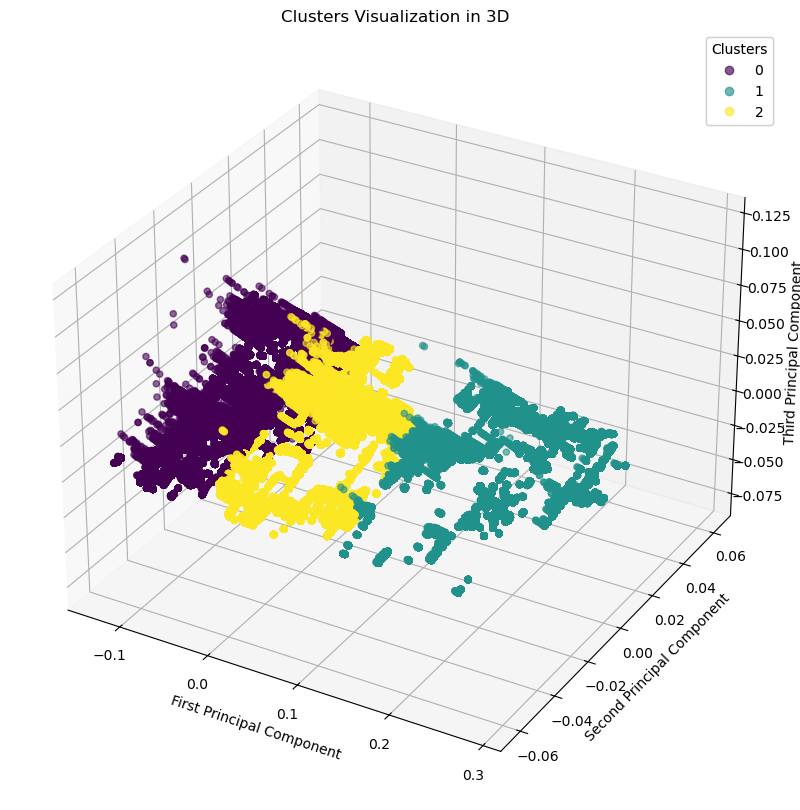

In [215]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], X_pca_reduced[:, 2], c=clusters, cmap='viridis', alpha=0.6)

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('Clusters Visualization in 3D')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [31]:
%%time

X_train_transformed_sample2 = resample(X_pca_reduced, n_samples=100000, random_state=42)

tSNE2 = TSNE(random_state=42, verbose=1)
digits_proj_sample2 = tSNE2.fit_transform(X_train_transformed_sample2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.025s...
[t-SNE] Computed neighbors for 100000 samples in 1.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probabi

In [32]:
kmeans2 = KMeans(n_clusters=3, random_state=42)
clusters2 = kmeans2.fit_predict(digits_proj_sample2)

In [38]:
print("Number of components after dimensionality reduction:", digits_proj_sample2.shape)


Number of components after dimensionality reduction: (100000, 2)


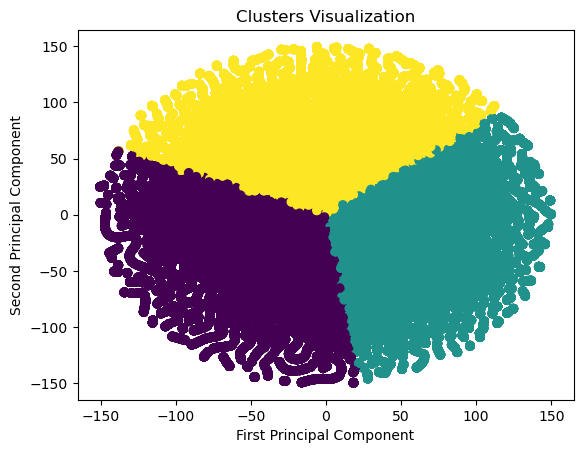

In [33]:
plt.scatter(digits_proj_sample2[:, 0], digits_proj_sample2[:, 1], c=clusters2, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters Visualization')
plt.show()

In [34]:
sample_size2 = min(10000, len(digits_proj_sample2))
indices2 = np.random.choice(len(digits_proj_sample2), sample_size2, replace=False)
X_sample2 = digits_proj_sample2[indices2]
clusters_sample2 = clusters2[indices2]

silhouette_avg2 = silhouette_score(X_sample2, clusters_sample2)
print(f"Silhouette Score: {silhouette_avg2}")

Silhouette Score: 0.361067533493042


In [35]:
inertia2 = kmeans2.inertia_
print(f"Inertia: {inertia2}")

Inertia: 378774656.0


In [36]:
db_index2 = davies_bouldin_score(digits_proj_sample2, clusters2)
print(f"Davies-Bouldin Index: {db_index2}")

Davies-Bouldin Index: 0.8830634184244124


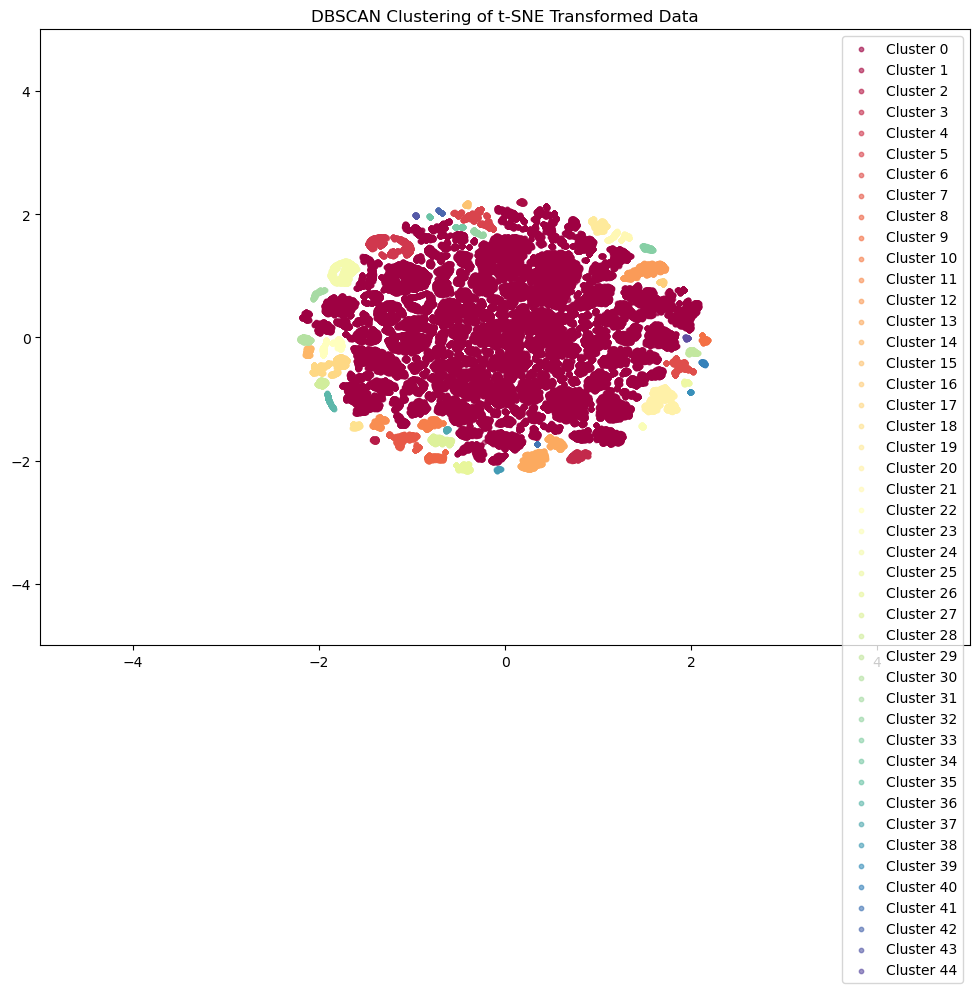

In [157]:
scaler = StandardScaler()
digits_proj_sample2 = scaler.fit_transform(digits_proj_sample2)

dbscan = DBSCAN(eps=0.1, min_samples=1)
dbscan_labels = dbscan.fit_predict(digits_proj_sample2)

# Plot the clusters
plt.figure(figsize=(12, 8))
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan_labels == k)

    xy = digits_proj_sample2[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=10, color=tuple(col), label=f'Cluster {k}', alpha=0.6)

plt.title('DBSCAN Clustering of t-SNE Transformed Data')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.show()

## TSNE

In [66]:
def scatter_tsne(x):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    unique_colors = np.linspace(0, 1, len(x))
    palette = plt.cm.rainbow(unique_colors)

    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette)

    plt.xlim(np.min(x[:,0])-0.1, np.max(x[:,0])+0.1)
    plt.ylim(np.min(x[:,1])-0.1, np.max(x[:,1])+0.1)
    
    ax.axis('off')
    ax.axis('tight')

    return f, ax, sc

In [37]:
%%time

X_train_transformed_sample = resample(X_train_transformed, n_samples=100000, random_state=42)

tSNE = TSNE(random_state=42, verbose=1)
digits_proj_sample = tSNE.fit_transform(X_train_transformed_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.014s...
[t-SNE] Computed neighbors for 100000 samples in 12.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x17d000626d0>)

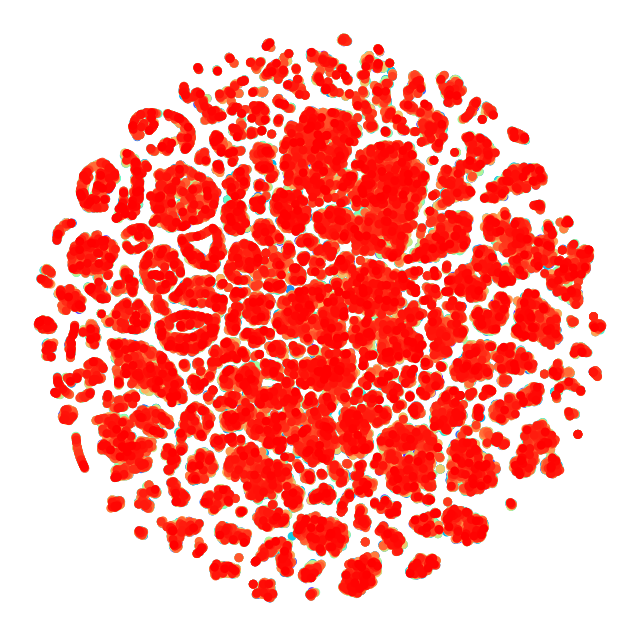

In [140]:
scatter_tsne(digits_proj_sample2)

## PCA for each device

In [216]:
# We categorize the data based on the originating device.

devices = {
    'location_group': [ 'seconds_elapsed_location', 'bearingAccuracy_location',
                        'speedAccuracy_location', 'verticalAccuracy_location',
                        'horizontalAccuracy_location', 'speed_location', 'bearing_location',
                        'altitude_location', 'longitude_location', 'latitude_location'],
    'orientation_group': ['seconds_elapsed_orientation', 'qz_orientation',
                        'qy_orientation', 'qx_orientation', 'qw_orientation',
                        'roll_orientation', 'pitch_orientation', 'yaw_orientation',],
    'total_acceleration_group': ['seconds_elapsed_total_acceleration', 'z_total_acceleration',
                        'y_total_acceleration', 'x_total_acceleration'],
    'magentometer_group':['seconds_elapsed_magnetometer', 'z_magnetometer', 'y_magnetometer',
                         'x_magnetometer'],
    'accelerometer_group':['seconds_elapsed_accelerometer', 'z_accelerometer',
                        'y_accelerometer', 'x_accelerometer'],
    'location_gps_group':['seconds_elapsed_location_gps',
                    'bearingAccuracy_location_gps', 'speedAccuracy_location_gps',
                    'verticalAccuracy_location_gps', 'horizontalAccuracy_location_gps',
                    'speed_location_gps', 'bearing_location_gps', 'altitude_location_gps',
                    'longitude_location_gps', 'latitude_location_gps'],
    'gyroscope_group':['seconds_elapsed_gyroscope', 'z_gyroscope', 'y_gyroscope',
                    'x_gyroscope'],
    'pedometer_group':['seconds_elapsed_pedometer', 'steps_pedometer'],
    'location_network_group':['seconds_elapsed_location_network', 'bearingAccuracy_location_network',
                    'speedAccuracy_location_network', 'verticalAccuracy_location_network',
                    'horizontalAccuracy_location_network', 'speed_location_network',
                    'bearing_location_network', 'altitude_location_network',
                    'longitude_location_network', 'latitude_location_network'],
    'gravity_group':['seconds_elapsed_gravity', 'z_gravity', 'y_gravity', 'x_gravity']
}

In [40]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [41]:
# Decision to use PCA for each device:
# The first step involves applying PCA to the data from each device, retaining only their first component.
# Utilizing PCA is advantageous as it enables dimensionality reduction and eliminates correlations between variables,
# which is particularly crucial for data originating from different sensors that may have varying scales and units.
# Retaining only the first component preserves the most significant features of the data while reducing its dimensionality.
# Subsequently, based on the PCA results for each device, we conduct the final transformation
# into a two-dimensional space using PCA, enabling data visualization and analysis of patterns across devices.

In [42]:
group_pca_results = pd.DataFrame()
for group_name, columns in devices.items():
    pipeline = Pipeline([
        ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
        ('selector', ColumnSelector(columns=columns)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1))
    ])
    pca_result = pipeline.fit_transform(X_train)
    group_pca_results[group_name] = pca_result.flatten()


In [40]:
group_pca_results

,location_group,orientation_group,total_acceleration_group,magentometer_group,accelerometer_group,location_gps_group,gyroscope_group,pedometer_group,location_network_group,gravity_group
0,1.286949,0.995369,0.896543,0.202076,-0.786841,-2.267884,0.931829,3.414791,0.166272,0.499945
1,0.970178,1.443131,0.248386,-0.764515,0.283522,-1.444179,-0.278888,2.053330,0.166272,0.256931
2,-1.544776,-0.840796,0.670025,-1.423068,-0.618162,-0.730751,-0.084284,0.618295,3.495257,1.033391
3,-0.940009,1.100068,-0.277826,0.003122,-0.493028,-0.732108,-0.561056,-0.312044,0.166272,-0.288989
4,0.665972,-0.283583,-0.587647,1.071452,-0.629058,-1.508517,1.600475,-0.579177,-1.276561,-0.827755
...,...,...,...,...,...,...,...,...,...,...
1543562,-0.033870,0.588443,2.424455,-2.631281,-0.021746,1.054573,0.012354,2.179862,-1.637775,2.681413
1543563,2.072464,2.737400,0.998270,-0.550398,0.194089,-0.480924,2.485830,0.383802,-1.260196,1.931418
1543564,1.913177,0.699848,0.480337,-0.793867,0.241719,-1.214129,0.307278,1.828091,0.166272,-0.192415
1543565,2.024923,2.310188,3.054222,-0.623078,-0.175260,-0.676144,-2.154432,0.353504,-1.254056,1.442190


In [41]:
pca_per_device = PCA(n_components=2)
final_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('final_pca', pca_per_device)
])

In [42]:
final_pca_transformed = final_pca_pipeline.fit_transform(group_pca_results)
final_pca_df = pd.DataFrame(final_pca_transformed, columns=['PC1', 'PC2'])

In [43]:
print(f'Total variance: {np.sqrt(np.std(group_pca_results)).iloc[0]:.4f}')
print(f'Explained variance: {pca_per_device.explained_variance_[0]:.4f}')
print(pca_per_device.explained_variance_ratio_)

Total variance: 1.2479
Explained variance: 4.8454
[0.48454463 0.12161065]


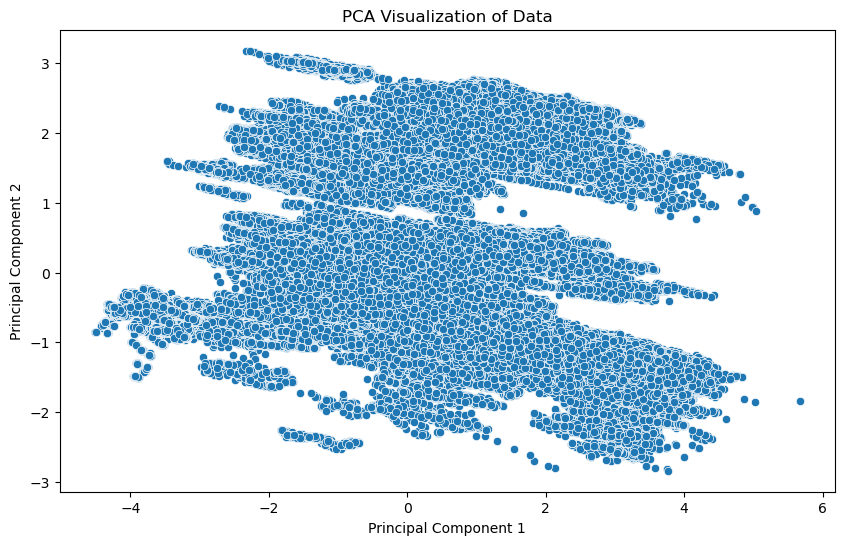

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=final_pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [45]:
pca_per_device_test = PCA().fit(group_pca_results)

Text(0, 0.5, 'cumulative explained variance')

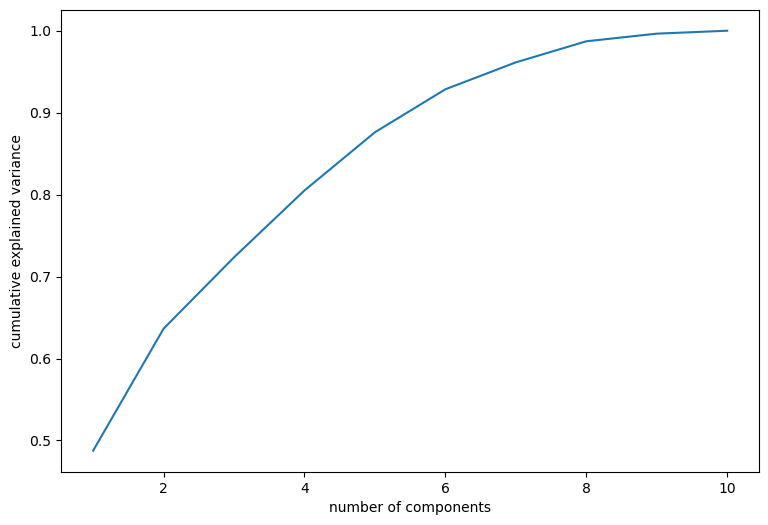

In [46]:
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca_per_device_test.explained_variance_ratio_)+1), np.cumsum(pca_per_device_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Testing models

In [47]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(final_pca_df)

labels = kmeans.labels_
print(labels)

[1 1 0 ... 1 1 0]


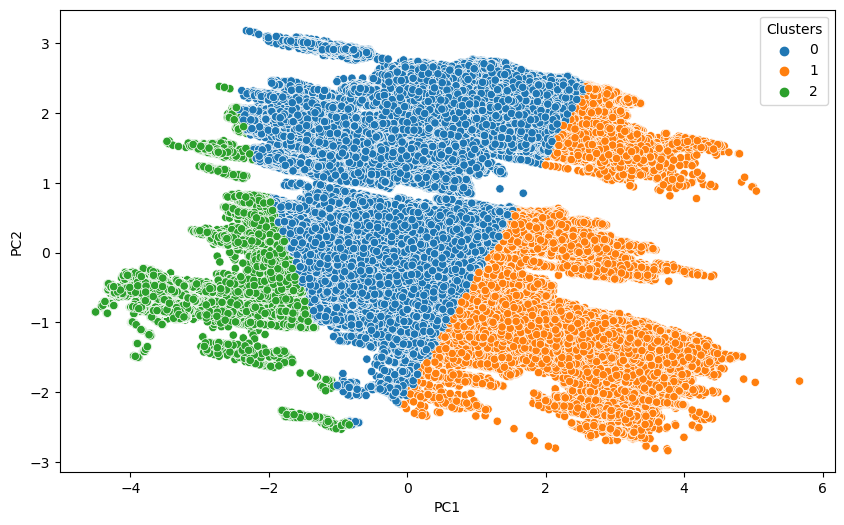

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_pca_df['PC1'], y=final_pca_df['PC2'], hue=labels, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [49]:
# Due to performance issues, we're using only a sample of the data, as running DBSCAN on 
# 1.5 million records caused the kernel to crash.

sampled_data = final_pca_df.sample(n=20000, random_state=42)
dbscan = DBSCAN(eps=0.3, min_samples=4)
dbscan.fit(sampled_data)
db_labels = dbscan.labels_
print(db_labels)

[ 0 -1  1 ...  1  1  1]


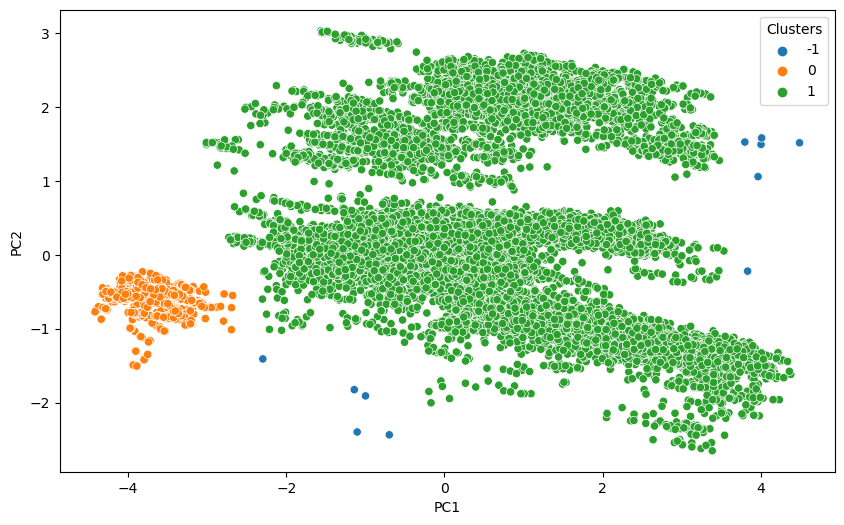

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sampled_data['PC1'], y=sampled_data['PC2'], hue=db_labels, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Comment on PCA Approach for Devices

Initially, we considered a strategy where we would apply Principal Component Analysis (PCA) to each device separately, extracting just one component per device. Subsequently, we planned to apply another PCA on these extracted components. However, we decided to drop this idea because we observed that too much information is lost in the first steps of our analysis. By reducing each device's data to a single component, we lose significant variance and essential information, which negatively impacts the overall analysis and clustering results. Therefore, we are opting for a more comprehensive dimensionality reduction approach that retains more information from the original data.


## Testing dimensionality reduction methods on different models

In our initial exploration, we found that basic PCA did not yield satisfactory results when applied directly to our dataset. Therefore, we are now experimenting with alternative dimensionality reduction techniques to assess their impact on the performance of clustering algorithms. By testing methods such as t-SNE and UMAP, we aim to discover if these approaches can capture more complex relationships in the data, potentially leading to improved clustering outcomes. This iterative process allows us to iteratively refine our analysis and select the most suitable combination of dimensionality reduction and clustering algorithms for our dataset.


In [217]:
def test_clustering_algorithms(X, cluster_num=3):
    results = []

    kmeans = KMeans(n_clusters=cluster_num)
    labels_kmeans = kmeans.fit_predict(X)
    sil_score_kmeans = silhouette_score(X, labels_kmeans)
    db_score_kmeans = davies_bouldin_score(X, labels_kmeans)
    ch_score_kmeans = calinski_harabasz_score(X, labels_kmeans)
    inertia_kmeans = kmeans.inertia_
    results.append(('KMeans', sil_score_kmeans, db_score_kmeans, ch_score_kmeans, inertia_kmeans))

    gmm = GaussianMixture(n_components=cluster_num)
    labels_gmm = gmm.fit_predict(X)
    sil_score_gmm = silhouette_score(X, labels_gmm)
    db_score_gmm = davies_bouldin_score(X, labels_gmm)
    ch_score_gmm = calinski_harabasz_score(X, labels_gmm)
    results.append(('GMM', sil_score_gmm, db_score_gmm, ch_score_gmm, None))
    
    agglo = AgglomerativeClustering(n_clusters=cluster_num)
    labels_agglo = agglo.fit_predict(X)
    sil_score_agglo = silhouette_score(X, labels_agglo)
    db_score_agglo = davies_bouldin_score(X, labels_agglo)
    ch_score_agglo = calinski_harabasz_score(X, labels_gmm)
    results.append(('Agglomerative', sil_score_agglo, db_score_agglo, ch_score_agglo, None))

    return pd.DataFrame(results, columns=['Algorithm', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score', 'Inertia'])

In [218]:
sample_size = 10000
X_sampled = X_train_transformed.sample(n=sample_size, random_state=42)

In [224]:
pca = PCA(n_components=3) #min 3 components to get ~0.95 cumulative explained variance
X_pca_reduced = pca.fit_transform(X_sampled)
results_pca = test_clustering_algorithms(X_pca_reduced)
print("PCA Results:")
print(results_pca)

PCA Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.948516               0.07991   
1            GMM          0.948516               0.07991   
2  Agglomerative          0.948516               0.07991   

   Calinski-Harabasz Score    Inertia  
0             1.975887e+06  18.401613  
1             1.975887e+06        NaN  
2             1.975887e+06        NaN  


In [220]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne_reduced = tsne.fit_transform(X_sampled)
results_tsne = test_clustering_algorithms(X_tsne_reduced)
print("t-SNE Results:")
print(results_tsne)

t-SNE Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.369246              0.883399   
1            GMM          0.360297              0.889569   
2  Agglomerative          0.308983              1.017503   

   Calinski-Harabasz Score     Inertia  
0              7388.423250  17125192.0  
1              7177.965323         NaN  
2              7177.965323         NaN  


In [221]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap_reduced = umap_reducer.fit_transform(X_sampled)
results_umap = test_clustering_algorithms(X_umap_reduced)
print("UMAP Results:")
print(results_umap)

UMAP Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.418055              0.808544   
1            GMM          0.409030              0.794290   
2  Agglomerative          0.368335              0.876970   

   Calinski-Harabasz Score     Inertia  
0              8960.558637  672472.875  
1              8092.255506         NaN  
2              8092.255506         NaN  


In [222]:
tsne_pca = TSNE(n_components=2, random_state=42)
X_tsne_pca_reduced = tsne_pca.fit_transform(X_pca_reduced)
results_tsne_pca = test_clustering_algorithms(X_tsne_pca_reduced)
print("PCA-TSNE Results:")
print(results_tsne_pca)

PCA-TSNE Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.371402              0.872810   
1            GMM          0.370328              0.873722   
2  Agglomerative          0.366474              0.874752   

   Calinski-Harabasz Score     Inertia  
0              7510.038319  16863892.0  
1              7475.830710         NaN  
2              7475.830710         NaN  


Components: 2, Distance Correlation: 0.5259736286128729
Components: 3, Distance Correlation: 0.5106182567543969
Components: 4, Distance Correlation: 0.5357793881966543
Components: 5, Distance Correlation: 0.5308205114291086
Components: 6, Distance Correlation: 0.5538509699465693
Components: 7, Distance Correlation: 0.5535076480248793
Components: 8, Distance Correlation: 0.5678908271716585
Components: 9, Distance Correlation: 0.6055931952901131
Components: 10, Distance Correlation: 0.6004833038435438
Components: 11, Distance Correlation: 0.599798021398562


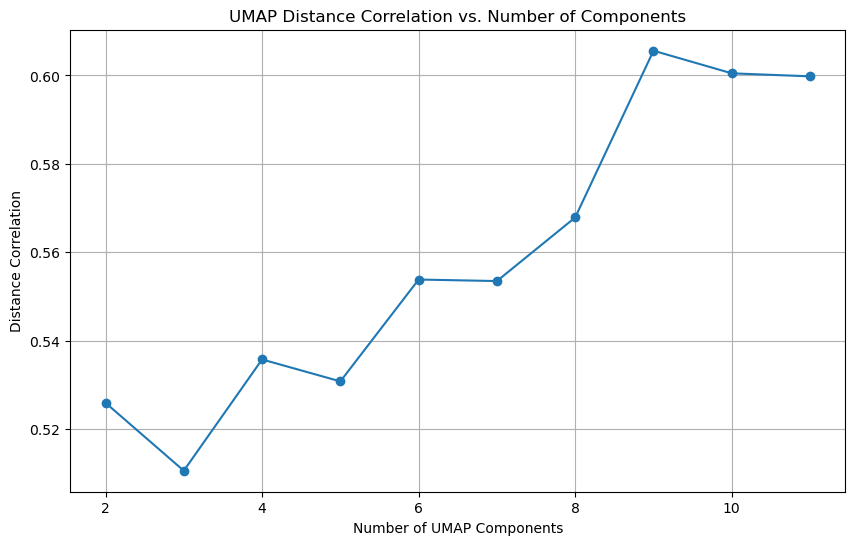

Optimal number of UMAP components: 9


In [223]:
# umap information

def calculate_distance_correlation(X_original, X_reduced):
    original_distances = pdist(X_original, metric='euclidean')
    reduced_distances = pdist(X_reduced, metric='euclidean')
    correlation = np.corrcoef(original_distances, reduced_distances)[0, 1]
    return correlation

component_range = range(2, 12)
correlations = []

for n_components in component_range:
    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    X_umap_reduced = umap_reducer.fit_transform(X_sampled)
    correlation = calculate_distance_correlation(X_sampled, X_umap_reduced)
    correlations.append(correlation)
    print(f"Components: {n_components}, Distance Correlation: {correlation}")

plt.figure(figsize=(10, 6))
plt.plot(component_range, correlations, marker='o')
plt.title('UMAP Distance Correlation vs. Number of Components')
plt.xlabel('Number of UMAP Components')
plt.ylabel('Distance Correlation')
plt.grid(True)
plt.show()

optimal_components = component_range[np.argmax(correlations)]
print(f"Optimal number of UMAP components: {optimal_components}")

PCA with 4 components was considered as an alternative for dimensionality reduction. However, based on the evaluation metrics such as Silhouette Score and Davies-Bouldin Index, UMAP was chosen as the preferred method. UMAP's flexibility in preserving both global and local structures of the data is expected to yield better clustering results.


In [116]:
pca = PCA(n_components=3) #min 3 components to get ~0.95 cumulative explained variance
X_pca = pca.fit_transform(X_train_transformed)

In [111]:
def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [117]:
metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
            'davies bouldin': davies_bouldin_score,
            'calinski harabasz': calinski_harabasz_score, 
           }

models = {
          'Kmeans': KMeans,
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single')
         }


df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        df.loc[model_key, metric_key] = count_clustering_scores(X=X_pca, cluster_num=3,
                                                                model=models[model_key],
                                                                score_fun=metrices[metric_key])

: 

In [ ]:
df

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies bouldin,calinski harabasz
Kmeans,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative ward linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative complete linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative average linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative single linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814


### Now, let's try applying KMeans and Agglomerative Clustering with average linkage method since they appear to yield the best results on our sample dataset.


In [114]:
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

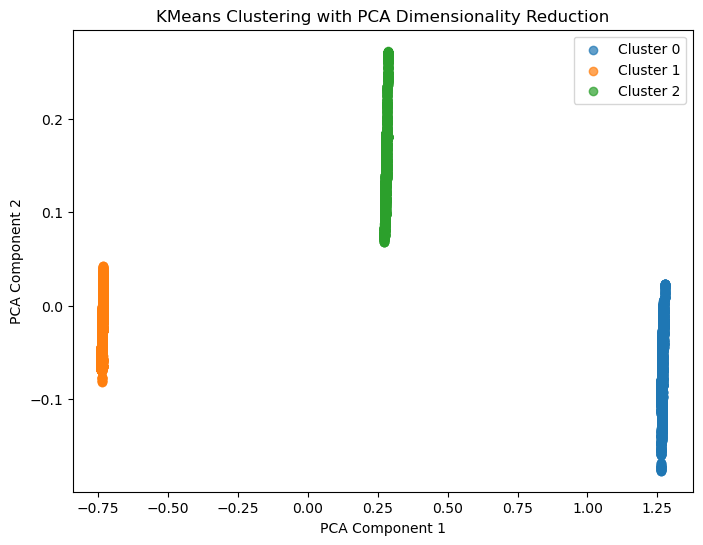

In [115]:
plt.figure(figsize=(8, 6))
for cluster in range(3):
    plt.scatter(X_pca[clusters_pca == cluster, 0], 
                X_pca[clusters_pca == cluster, 1], 
                label=f'Cluster {cluster}', alpha=0.7)  
plt.legend()
plt.title('KMeans Clustering with PCA Dimensionality Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [46]:
agglomerativeClustering_average_umap = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters_umap_sample_ac = agglomerativeClustering_average_umap.fit(X_umap_reduced)

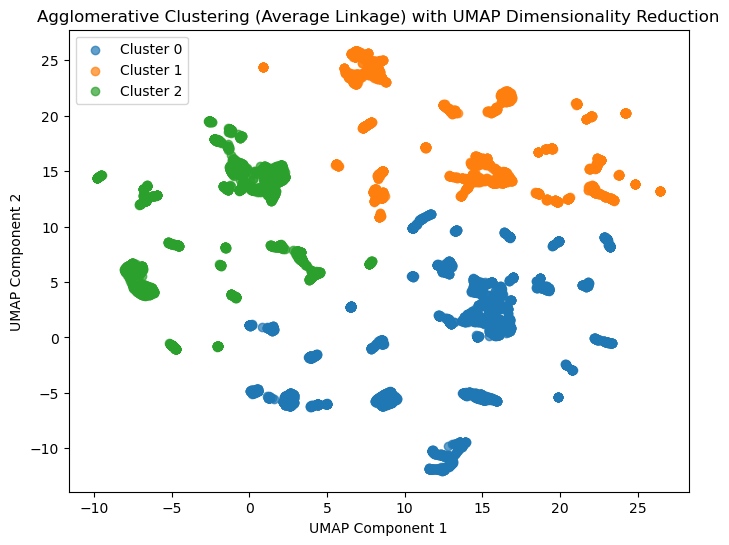

In [47]:
plt.figure(figsize=(8, 6))

for cluster in range(3): 
    plt.scatter(X_umap_reduced[clusters_umap_sample_ac.labels_ == cluster, 0],
                X_umap_reduced[clusters_umap_sample_ac.labels_ == cluster, 1],
                label=f'Cluster {cluster}', alpha=0.7) 
plt.legend()
plt.title('Agglomerative Clustering (Average Linkage) with UMAP Dimensionality Reduction')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [48]:
# 10k sample -> 100k sample

sample_size = 100000
X_sampled_100 = X_train_transformed.sample(n=sample_size, random_state=42)

In [70]:
umap_reducer = umap.UMAP(n_components=3, random_state=42)
X_umap_reduced100 = umap_reducer.fit_transform(X_sampled_100)

In [71]:
kmeans_umap_sample100 = KMeans(n_clusters=3, random_state=42)
clusters_umap_sample100 = kmeans_umap_sample100.fit_predict(X_umap_reduced100)

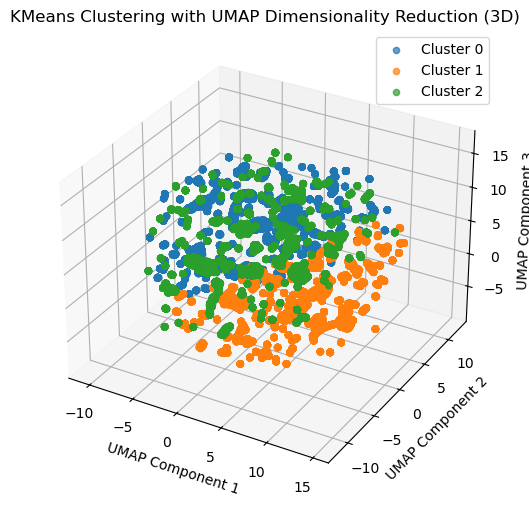

In [72]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(3):
    ax.scatter(X_umap_reduced100[clusters_umap_sample100 == cluster, 0], 
                X_umap_reduced100[clusters_umap_sample100 == cluster, 1], 
                X_umap_reduced100[clusters_umap_sample100 == cluster, 2], 
                label=f'Cluster {cluster}', alpha=0.7)
ax.legend()
ax.set_title('KMeans Clustering with UMAP Dimensionality Reduction (3D)')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()


In [73]:
silhouette_avg = silhouette_score(X_umap_reduced100, clusters_umap_sample100)
print(f'Silhouette Score: {silhouette_avg}')

davies_bouldin_avg = davies_bouldin_score(X_umap_reduced100, clusters_umap_sample100)
print(f'Davies-Bouldin Index: {davies_bouldin_avg}')

calinski_harabasz_avg = calinski_harabasz_score(X_umap_reduced100, clusters_umap_sample100)
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')

Silhouette Score: 0.2580057382583618
Davies-Bouldin Index: 1.3224349118347611
Calinski-Harabasz Score: 35722.354131276385
